In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras_preprocessing.image import load_img
from PIL import ImageOps
import cv2
keras.backend.clear_session()
import time

# Load and preview dataset

In [2]:
start = time.time()

# Change to path where images and masks are stored
path_to_folder = '/Users/daniel/Desktop/downloaded_images'

input_paths = []
target_paths = []
for root, dirs, files in os.walk(path_to_folder):
    for file in files:
        path = os.path.join(root, file)

        if file == '.DS_Store':
            continue
       
        if 'mask' in file:
            target_paths.append(path)
        else:
            input_paths.append(path)

print(f"Data size: {len(input_paths)}")
input_paths.sort()
target_paths.sort()

Data size: 252


## Sample corresponding mask and image to visualize

Sample number 0


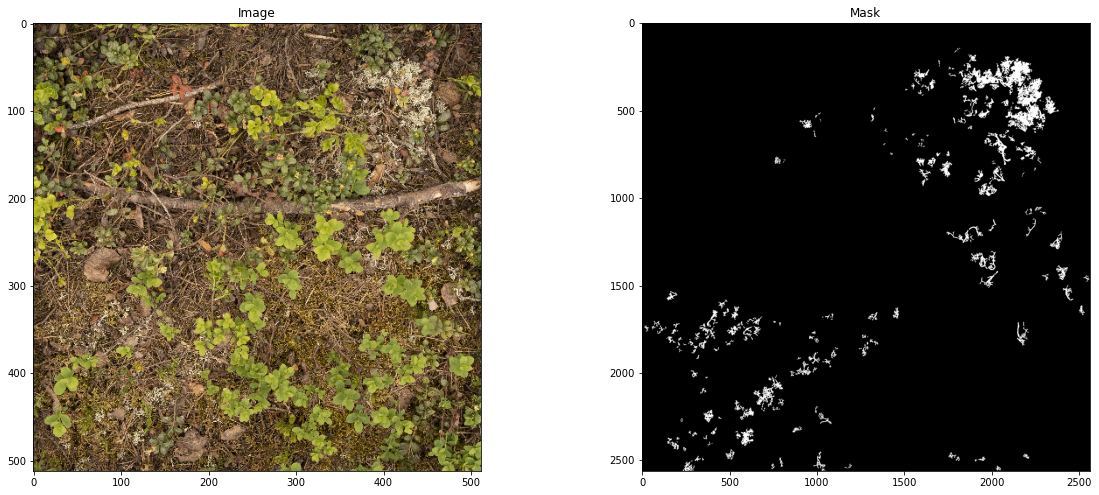

Image shape: (2560, 2560, 3)
Mask shape: (2560, 2560, 3)
[  0 255]
Sample number 1


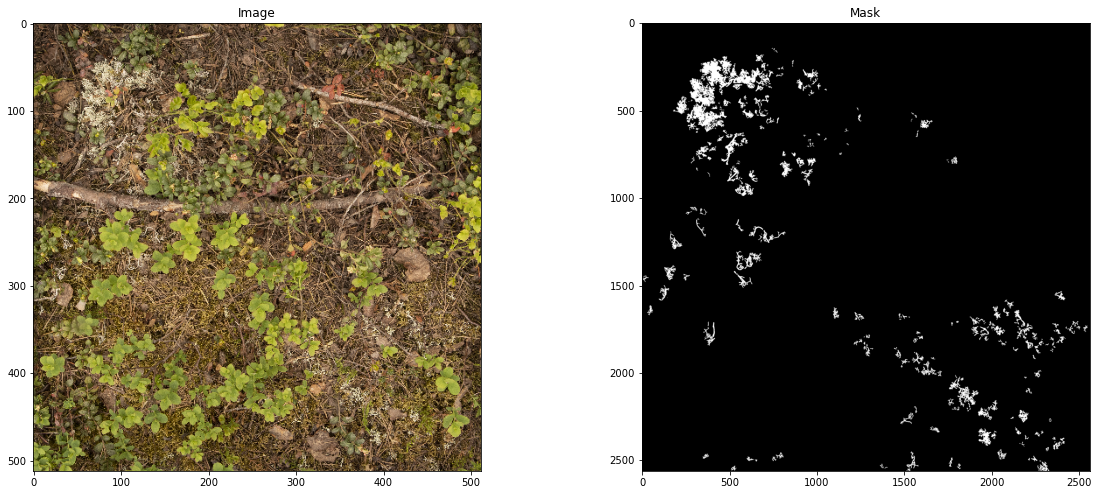

Image shape: (2560, 2560, 3)
Mask shape: (2560, 2560, 3)
[  0 255]
Sample number 2


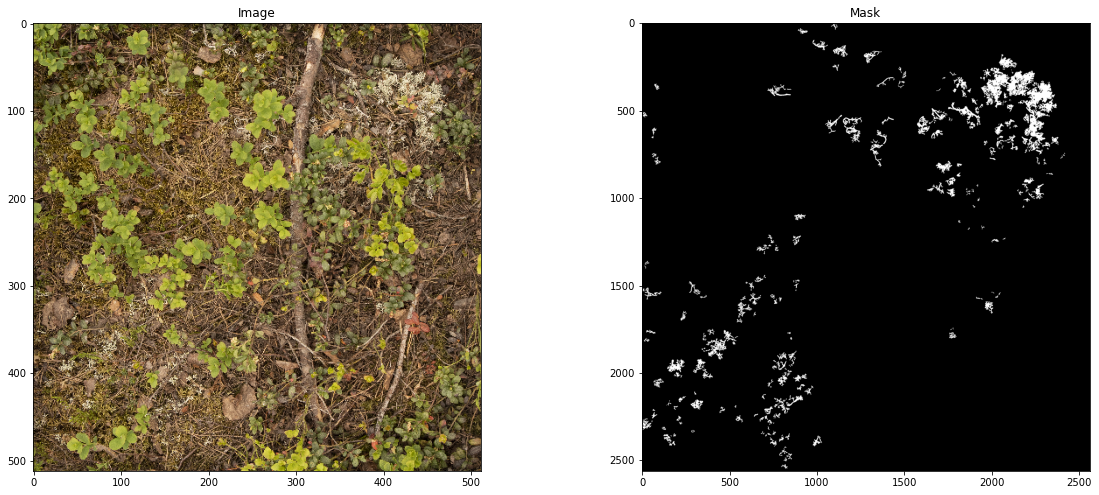

Image shape: (2560, 2560, 3)
Mask shape: (2560, 2560, 3)
[  0 255]


In [11]:


num_samples = 3
k = 0
for i in range(num_samples):
    plt.figure(figsize=(20, 28))
    print(f"Sample number {i}")
    plt.subplot(num_samples, 2, 1 + k * 2)
    plt.imshow(load_img(input_paths[i], target_size=(512, 512), color_mode="rgb"))
    plt.title("Image")

    
    plt.subplot(num_samples, 2, 2 + k*2)
    plt.imshow(ImageOps.autocontrast(load_img(target_paths[i])))
    plt.title("Mask")
    plt.show()

    print(f"Image shape: {np.shape(load_img(input_paths[i]))}")
    # mask = load_img(target_paths[i], color_mode="grayscale")
    mask = cv2.imread(target_paths[i])
    	
    (thresh, mask) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    print(f"Mask shape: {np.shape(mask)}")
    print(np.unique(mask))



## Prepare dataset for training

In [17]:
img_size = (1024, 1024)
num_classes = 2
batch_size = 4

In [18]:
class DataLoader(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths) -> None:
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def getImagePath(self, batch_idx, idx):
        
        batch_idx = batch_idx * self.batch_size
        return self.input_img_paths[batch_idx: batch_idx + self.batch_size][idx]


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns (input, target) corresponding to batch idx"""

        idx = idx * self.batch_size


        batch_input_img_paths = self.input_img_paths[idx:idx+self.batch_size]

        batch_target_img_paths = self.target_img_paths[idx:idx+self.batch_size]
        # Fetch and resize input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for i, path in enumerate(batch_input_img_paths):

            img = load_img(path, target_size=self.img_size)
            x[i] = img

            
        # Fetch and resize target images
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for i, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = img.point(lambda x: 1 if x > 130 else 0)
            y[i] = np.expand_dims(img, 2)


        
        return x, y


# Setup the model

In [14]:
# Pre-trained DenseNet121
base = keras.applications.DenseNet121(input_shape=[img_size[0], img_size[1], 3],
include_top=False,
weights="imagenet")

29084464/29084464 [==============================] - 4s 0us/step


In [15]:
# Check how many layers this network already has
print(len(base.layers))

427


### Build downstack

In [16]:
# Introduce skip connections, read more about ut here: https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]
skip_layer_outputs = [base.get_layer(name).output for name in skip_names]

# Layers taken by looking at the keras.utils.plot_model output

# Build the downstack part of our Unet with these layers

downstack = keras.Model(
    inputs=base.input,
    outputs=skip_layer_outputs
)
# We don't want to train the downstack layers
downstack.trainable = False

### Build upstack

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix


upstack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

### Combine the two stacks into a U-Net model

In [ ]:
inputs = keras.layers.Input(shape=[img_size[0], img_size[1], 3])
down = downstack(inputs)
out = down[-1] # output from the down stack

# Skip connections
skip_connections = reversed(down[:-1]) # Last down connects to first up and so on, also the last layer does not 'skip'

for up_layer, skip_layer in zip(upstack, skip_connections):
    out = up_layer(out)
    out = keras.layers.Concatenate()([out, skip_layer])

# Add final 'classification layer' 
out = keras.layers.Conv2DTranspose(num_classes, 3, strides=2, padding="same")(out)


# Complete the model
unet = keras.Model(inputs=inputs, outputs=out)


# Summarize model
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_3 (Functional)           [(None, 512, 512, 6  7037504     ['input_6[0][0]']                
                                4),                                                               
                                 (None, 256, 256, 2                                               
                                56),                                                              
                                 (None, 128, 128, 5                                         

# Train the model

### Create Train and Validation sets

In [ ]:
import random
validation_samples = 40 # We only have 400 images
random.shuffle(input_paths)
random.shuffle(target_paths)

train_img_paths = input_paths[:-validation_samples]
train_target_paths = target_paths[:-validation_samples]

val_img_paths = input_paths[-validation_samples:]
val_target_paths = target_paths[-validation_samples:]

train_set = DataLoader(batch_size=batch_size, img_size=img_size, input_img_paths=train_img_paths, target_img_paths=train_target_paths)
val_set = DataLoader(batch_size=batch_size, img_size=img_size, input_img_paths=val_img_paths, target_img_paths=val_target_paths)





## Preview Train images

Sample number 0
Image name: result/IMG_20221028_155938/original.jpg


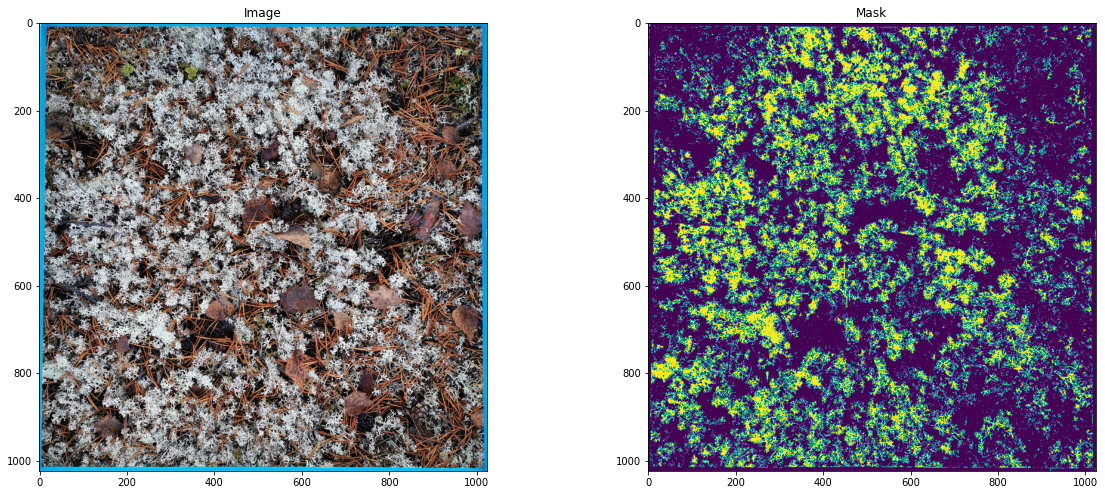

Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]
Sample number 1
Image name: result/IMG_0164/original.jpg


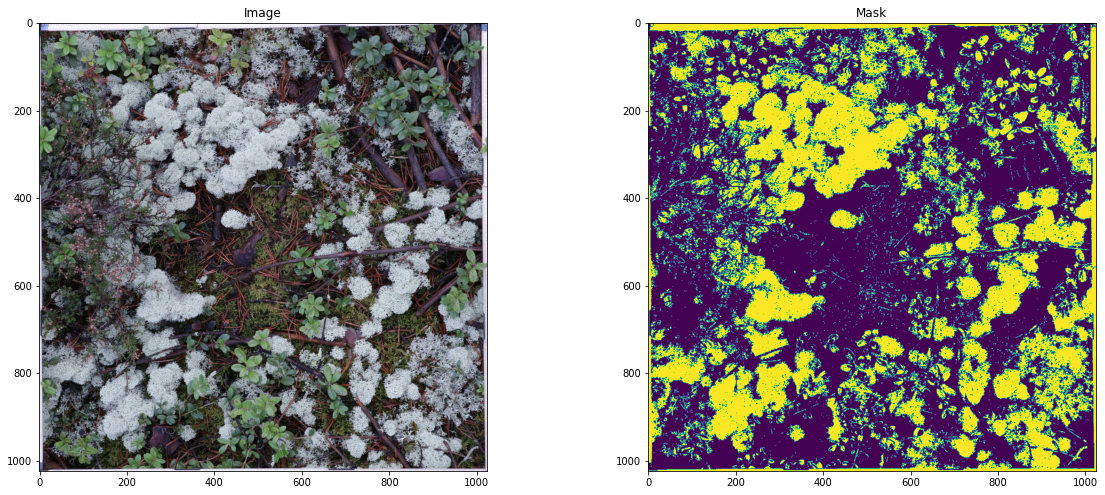

Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]
Sample number 2
Image name: result/IMG_20221101_123501/original.jpg


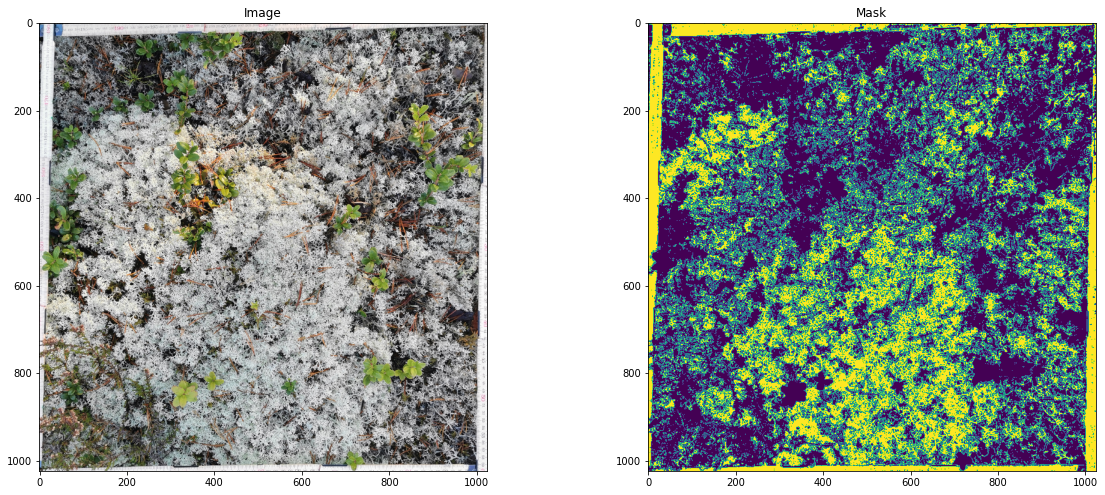

Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]


In [ ]:
num_samples = 3
k = 0
for i in range(num_samples):
    plt.figure(figsize=(20, 28))
    print(f"Sample number {i}")
    image = train_set.__getitem__(0)[0][i]


    
    plt.subplot(num_samples, 2, 1 + k * 2)
    plt.imshow(image)
    plt.title("Image")
    mask = train_set.__getitem__(0)[1][i]
    
    plt.subplot(num_samples, 2, 2 + k*2)
    plt.imshow(mask)
    plt.title("Mask")
    print(f"Image name: {train_set.getImagePath(0, i)}")
    plt.show()

    print(f"Image shape: {np.shape(image)}\nMask shape: {np.shape(mask)}")
    print(np.unique(mask))

### Compile the model and train

In [ ]:
unet.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "lichens-segmentation.h5",
        save_best=True # Save the best weights and not necessarily the last
    )
]



epochs = 100 # We don't have so much data so we might overfit with too many epochs?

unet.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
    verbose=0
)








Epoch 1/150
91/91 [==============================] - 49s 389ms/step - loss: 0.3260 - accuracy: 0.7985 - val_loss: 0.2779 - val_accuracy: 0.7536
Epoch 2/150
91/91 [==============================] - 34s 372ms/step - loss: 0.2354 - accuracy: 0.7863 - val_loss: 0.2982 - val_accuracy: 0.7195
Epoch 3/150
91/91 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.7842

2/2 [==============================] - 3s 1s/step


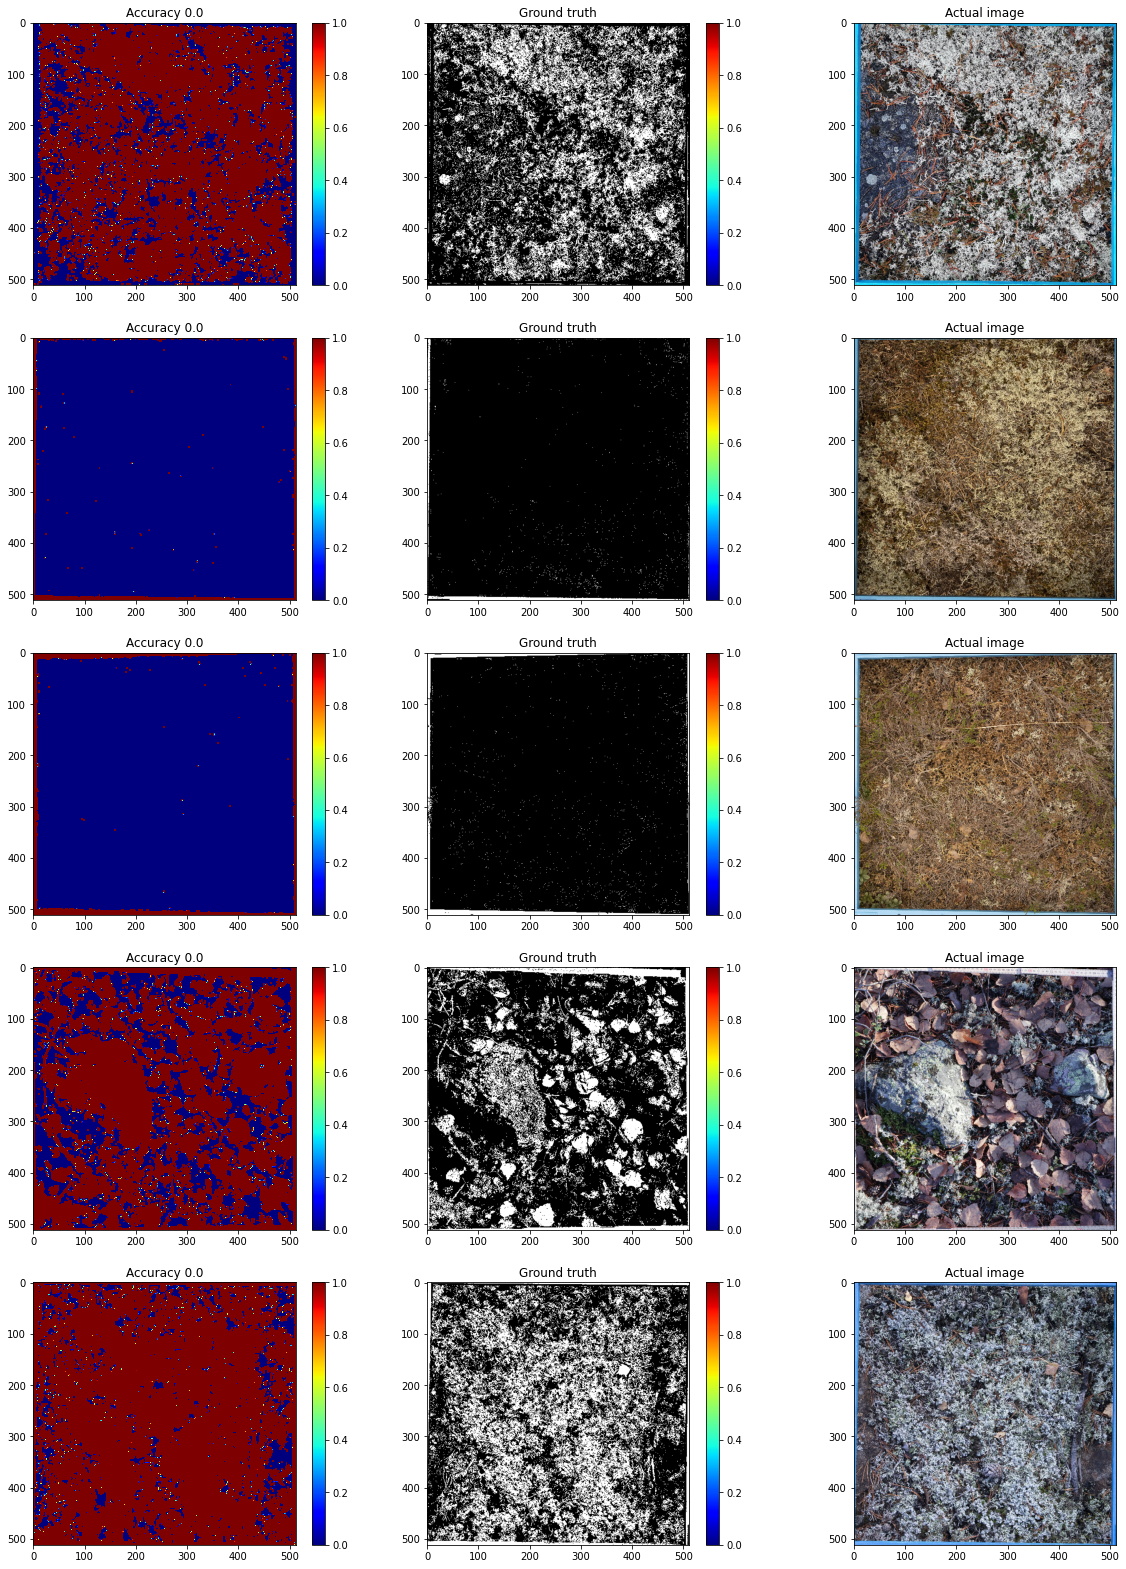

[-12.616664  -11.731659  -11.697795  ...  12.3054085  12.31419
  12.476876 ]


In [ ]:


unet.load_weights("lichens-segmentation.h5")
val_preds = unet.predict(val_set)

def get_pred(idx):
    mask = np.argmax(val_preds[idx], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img
    
NORM = mpl.colors.Normalize(vmin=0, vmax=num_classes - 1)

k = 0
n_examples = 5
plt.figure(figsize=(20, 28))
for i in range(n_examples):

    plt.subplot(n_examples, 3, 1 + k*3)

    # Show prediction
    pred = get_pred(i)
    plt.imshow(ImageOps.autocontrast(pred), norm=NORM)
    mean = np.mean(pred == ImageOps.autocontrast(load_img(val_target_paths[i], color_mode="rgb", target_size=img_size)))
    plt.title(f"Accuracy {mean}")
    plt.colorbar()
    plt.subplot(n_examples, 3, 2 + k*3)

    # Show ground truth
    plt.imshow(ImageOps.autocontrast(load_img(val_target_paths[i], color_mode="rgb", target_size=img_size)), norm=NORM)
    plt.title("Ground truth")
    plt.colorbar()
    plt.subplot(n_examples, 3, 3 + k*3)

    # Show image
    plt.imshow(load_img(val_img_paths[i], target_size=img_size))
    plt.title("Actual image")
    
    k += 1
    
plt.show()
print(np.unique(val_preds[0]))

In [ ]:

with open("done.txt", "w") as file:
    file.write(f"Execution time: {time.time() - start}")